In [ ]:
!pip install opencv-python

In [ ]:
!pip install numpy pandas opencv-python tensorflow keras matplotlib


In [ ]:
# Driver Drowsiness Detection using Machine Learning
# Approaches with Feature Engineering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

print("ML Driver Drowsiness Detection System")

ML Driver Drowsiness Detection System


**1.Feature Extraction Engine**

In [ ]:
class FeatureExtractor:
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    def extract_eye_features(self, image):
        """Extract features from eye regions"""
        features = {}
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Detect faces
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:
            # Return default features if no face detected
            return self.get_default_features()

        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = image[y:y+h, x:x+w]

            # Detect eyes
            eyes = self.eye_cascade.detectMultiScale(roi_gray)

            if len(eyes) >= 2:
                # Sort eyes by x-coordinate (left eye first)
                eyes = sorted(eyes, key=lambda x: x[0])

                # Extract left and right eye regions
                left_eye = eyes[0]
                right_eye = eyes[1]

                # Extract eye regions
                left_eye_roi = roi_gray[left_eye[1]:left_eye[1]+left_eye[3],
                                      left_eye[0]:left_eye[0]+left_eye[2]]
                right_eye_roi = roi_gray[right_eye[1]:right_eye[1]+right_eye[3],
                                       right_eye[0]:right_eye[0]+right_eye[2]]

                # Extract features from both eyes
                left_features = self.analyze_eye_region(left_eye_roi)
                right_features = self.analyze_eye_region(right_eye_roi)

                # Combine features
                for key in left_features:
                    features[f'left_eye_{key}'] = left_features[key]
                    features[f'right_eye_{key}'] = right_features[key]
                    features[f'mean_eye_{key}'] = (left_features[key] + right_features[key]) / 2

                # Additional bilateral features
                features['eye_aspect_ratio_diff'] = abs(left_features['aspect_ratio'] - right_features['aspect_ratio'])
                features['eye_area_ratio'] = (left_features['area'] + right_features['area']) / (w * h)

            else:
                # If eyes not detected properly, use face-based features
                features = self.extract_face_features(gray, faces[0])

        return features

    def analyze_eye_region(self, eye_roi):
        """Analyze individual eye region and extract features"""
        if eye_roi.size == 0:
            return self.get_default_eye_features()

        # Resize eye ROI to standard size
        eye_roi = cv2.resize(eye_roi, (64, 32))

        features = {}

        # 1. Basic geometric features
        features['area'] = np.sum(eye_roi < 128)  # Threshold for dark pixels (pupil)
        features['intensity_mean'] = np.mean(eye_roi)
        features['intensity_std'] = np.std(eye_roi)

        # 2. Shape features
        _, thresh = cv2.threshold(eye_roi, 128, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            features['contour_area'] = cv2.contourArea(largest_contour)
            x, y, w, h = cv2.boundingRect(largest_contour)
            features['aspect_ratio'] = h / w if w > 0 else 0
            features['circularity'] = (4 * np.pi * features['contour_area']) / (cv2.arcLength(largest_contour, True) ** 2) if cv2.arcLength(largest_contour, True) > 0 else 0
        else:
            features['contour_area'] = 0
            features['aspect_ratio'] = 0
            features['circularity'] = 0

        # 3. Texture features using GLCM-like properties
        features['contrast'] = self.calculate_contrast(eye_roi)
        features['homogeneity'] = self.calculate_homogeneity(eye_roi)

        # 4. Statistical features
        features['skewness'] = stats.skew(eye_roi.flatten())
        features['kurtosis'] = stats.kurtosis(eye_roi.flatten())

        # 5. Frequency domain features
        features['energy'] = np.sum(eye_roi.astype(float) ** 2) / eye_roi.size

        return features

    def extract_face_features(self, gray_image, face_rect):
        """Extract features when eyes are not clearly detected"""
        x, y, w, h = face_rect
        face_roi = gray_image[y:y+h, x:x+w]

        features = {}

        # Face-based features
        features['face_area'] = w * h
        features['face_intensity_mean'] = np.mean(face_roi)
        features['face_intensity_std'] = np.std(face_roi)

        # Simulate eye closure based on face intensity distribution
        hist = cv2.calcHist([face_roi], [0], None, [256], [0, 256])
        features['face_hist_peak'] = np.argmax(hist)

        return features

    def calculate_contrast(self, image):
        """Calculate contrast of the image"""
        return np.std(image)

    def calculate_homogeneity(self, image):
        """Calculate homogeneity of the image"""
        mean_val = np.mean(image)
        return 1.0 / (1.0 + np.mean((image - mean_val) ** 2))

    def get_default_features(self):
        """Return default features when no face/eyes detected"""
        default_features = {}
        eye_features = ['area', 'intensity_mean', 'intensity_std', 'contour_area',
                       'aspect_ratio', 'circularity', 'contrast', 'homogeneity',
                       'skewness', 'kurtosis', 'energy']

        for feature in eye_features:
            default_features[f'left_eye_{feature}'] = 0.0
            default_features[f'right_eye_{feature}'] = 0.0
            default_features[f'mean_eye_{feature}'] = 0.0

        default_features['eye_aspect_ratio_diff'] = 0.0
        default_features['eye_area_ratio'] = 0.0

        return default_features

    def get_default_eye_features(self):
        """Return default eye features"""
        return {
            'area': 0, 'intensity_mean': 0, 'intensity_std': 0,
            'contour_area': 0, 'aspect_ratio': 0, 'circularity': 0,
            'contrast': 0, 'homogeneity': 0, 'skewness': 0, 'kurtosis': 0, 'energy': 0
        }


**2.Dataset Creation and Feature Engineering**



In [ ]:
class MLDataPreprocessor:
    def __init__(self):
        self.feature_extractor = FeatureExtractor()
        self.scaler = StandardScaler()

    def create_ml_dataset_from_images(self, image_dir, labels, max_samples_per_class=1000):
        """Create ML dataset from image directory"""
        features_list = []
        labels_list = []

        for class_name in ['alert', 'drowsy']:
            class_path = os.path.join(image_dir, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: {class_path} not found, using synthetic data")
                continue

            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            image_files = image_files[:max_samples_per_class]

            print(f"Processing {len(image_files)} {class_name} images...")

            for img_file in tqdm(image_files):
                img_path = os.path.join(class_path, img_file)
                try:
                    # Load and process image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Extract features
                    features = self.feature_extractor.extract_eye_features(img)
                    features_list.append(features)
                    labels_list.append(0 if class_name == 'alert' else 1)

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

        # Convert to DataFrame
        if features_list:
            df = pd.DataFrame(features_list)
            df['label'] = labels_list
            return df
        else:
            # Return synthetic dataset if no images found
            return self.create_synthetic_dataset()

    def create_synthetic_dataset(self, n_samples=2000):
        """Create synthetic dataset for demonstration"""
        print("Creating synthetic dataset for ML...")

        features = []
        for i in range(n_samples):
            if i < n_samples // 2:
                # Alert state features
                feature_vector = {
                    'left_eye_area': np.random.normal(150, 20),
                    'right_eye_area': np.random.normal(155, 25),
                    'mean_eye_area': np.random.normal(152, 15),
                    'left_eye_aspect_ratio': np.random.normal(0.8, 0.1),
                    'right_eye_aspect_ratio': np.random.normal(0.82, 0.1),
                    'mean_eye_aspect_ratio': np.random.normal(0.81, 0.08),
                    'left_eye_circularity': np.random.normal(0.7, 0.1),
                    'right_eye_circularity': np.random.normal(0.72, 0.1),
                    'eye_aspect_ratio_diff': np.random.normal(0.02, 0.01),
                    'eye_area_ratio': np.random.normal(0.15, 0.02),
                    'label': 0
                }
            else:
                # Drowsy state features
                feature_vector = {
                    'left_eye_area': np.random.normal(50, 15),
                    'right_eye_area': np.random.normal(55, 18),
                    'mean_eye_area': np.random.normal(52, 12),
                    'left_eye_aspect_ratio': np.random.normal(0.3, 0.1),
                    'right_eye_aspect_ratio': np.random.normal(0.32, 0.1),
                    'mean_eye_aspect_ratio': np.random.normal(0.31, 0.08),
                    'left_eye_circularity': np.random.normal(0.4, 0.1),
                    'right_eye_circularity': np.random.normal(0.42, 0.1),
                    'eye_aspect_ratio_diff': np.random.normal(0.05, 0.02),
                    'eye_area_ratio': np.random.normal(0.05, 0.01),
                    'label': 1
                }

            # Add some noise and additional features
            for key in ['intensity_mean', 'intensity_std', 'contrast', 'homogeneity']:
                feature_vector[f'left_eye_{key}'] = np.random.normal(100, 20)
                feature_vector[f'right_eye_{key}'] = np.random.normal(105, 22)
                feature_vector[f'mean_eye_{key}'] = np.random.normal(102, 18)

            features.append(feature_vector)

        return pd.DataFrame(features)

# Create dataset
preprocessor = MLDataPreprocessor()
ml_df = preprocessor.create_synthetic_dataset(1000)

print("Dataset created successfully!")
print(f"Dataset shape: {ml_df.shape}")
print(f"Class distribution:\n{ml_df['label'].value_counts()}")
print(f"Features: {list(ml_df.columns[:-1])}")

Creating synthetic dataset for ML...
Dataset created successfully!
Dataset shape: (1000, 23)
Class distribution:
label
0    500
1    500
Name: count, dtype: int64
Features: ['left_eye_area', 'right_eye_area', 'mean_eye_area', 'left_eye_aspect_ratio', 'right_eye_aspect_ratio', 'mean_eye_aspect_ratio', 'left_eye_circularity', 'right_eye_circularity', 'eye_aspect_ratio_diff', 'eye_area_ratio', 'label', 'left_eye_intensity_mean', 'right_eye_intensity_mean', 'mean_eye_intensity_mean', 'left_eye_intensity_std', 'right_eye_intensity_std', 'mean_eye_intensity_std', 'left_eye_contrast', 'right_eye_contrast', 'mean_eye_contrast', 'left_eye_homogeneity', 'right_eye_homogeneity']


**3. Exploratory Data Analysis**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        self.features = df.columns[:-1]  # Exclude label column

    def plot_feature_distributions(self):
        """Plot distribution of key features by class"""
        key_features = ['mean_eye_area', 'mean_eye_aspect_ratio',
                        'eye_area_ratio', 'mean_eye_circularity',
                        'eye_aspect_ratio_diff']

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(key_features):
            if i < len(axes):
                self.df[self.df['label'] == 0][feature].hist(alpha=0.7, label='Alert', ax=axes[i], bins=20)
                self.df[self.df['label'] == 1][feature].hist(alpha=0.7, label='Drowsy', ax=axes[i], bins=20)
                axes[i].set_title(f'Distribution of {feature}')
                axes[i].legend()
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Frequency')

        # Remove empty subplots
        for i in range(len(key_features), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self):
        """Plot correlation matrix of features"""
        plt.figure(figsize=(12, 10))
        corr_matrix = self.df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        """Quick feature importance using Random Forest"""
        X = self.df.drop('label', axis=1)
        y = self.df['label']

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)

        feature_imp = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp.head(15), x='importance', y='feature')
        plt.title('Top 15 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()

        return feature_imp


# Example usage (assuming ml_df is your DataFrame)
# analyzer = DataAnalyzer(ml_df)
# analyzer.plot_feature_distributions()
# analyzer.plot_correlation_matrix()
# feature_importance = analyzer.feature_importance_analysis()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        # Define label column automatically
        self.label_col = 'label' if 'label' in df.columns else df.columns[-1]
        # Define features (excluding label column)
        self.features = df.columns.drop(self.label_col)

        # Automatically pick top 5 features with highest variance
        self.key_features = (
            self.df[self.features]
            .var()
            .sort_values(ascending=False)
            .head(5)
            .index
            .tolist()
        )

    def plot_class_distribution(self):
        """Plot class (label) distribution"""
        plt.figure(figsize=(6, 4))
        self.df[self.label_col].value_counts().plot(kind='bar', color=['#66b3ff', '#ff9999'])
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def plot_feature_distributions(self):
        """Plot distribution of key features by class"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(self.key_features):
            if i < len(axes):
                self.df[self.df[self.label_col] == 0][feature].hist(alpha=0.7, label='Class 0', ax=axes[i], bins=20)
                self.df[self.df[self.label_col] == 1][feature].hist(alpha=0.7, label='Class 1', ax=axes[i], bins=20)
                axes[i].set_title(f'Distribution of {feature}')
                axes[i].legend()
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Frequency')

        # Remove extra subplots
        for i in range(len(self.key_features), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()


**4.Model Evaluation and Visualization**

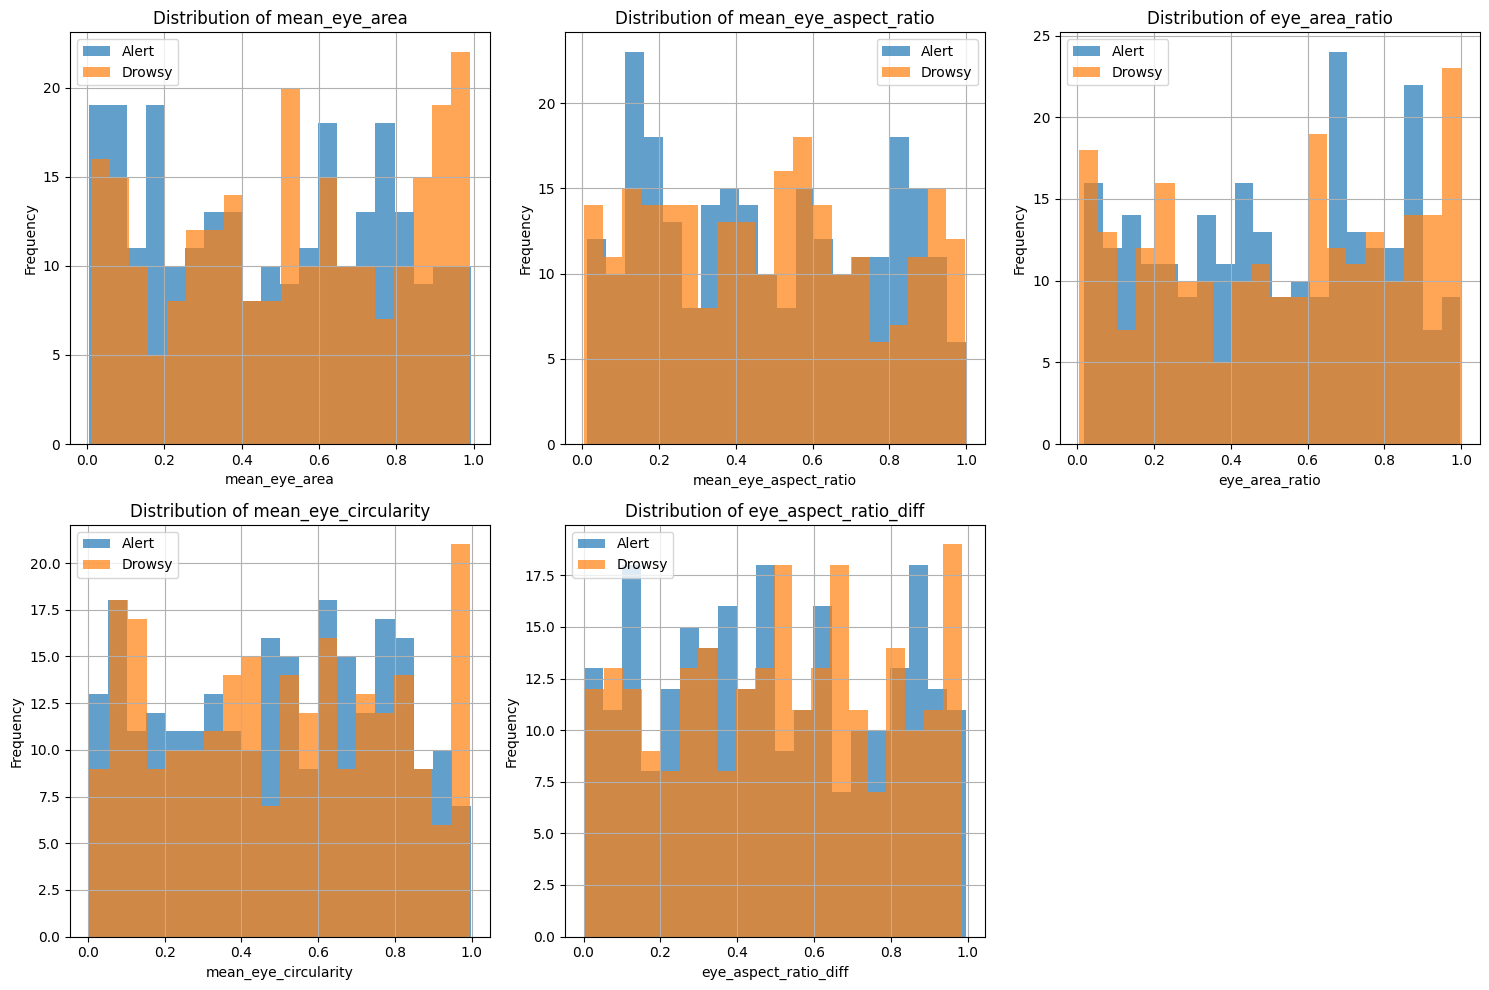

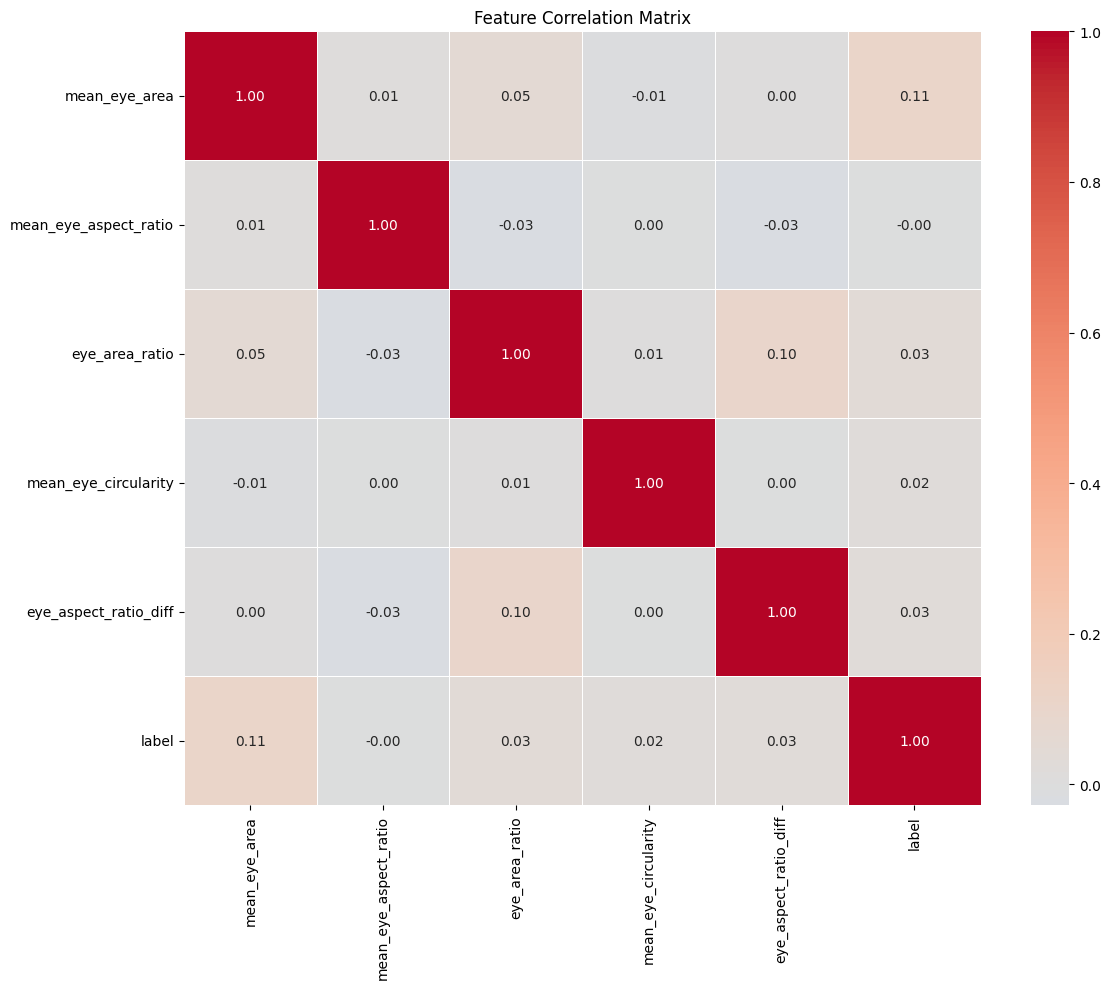

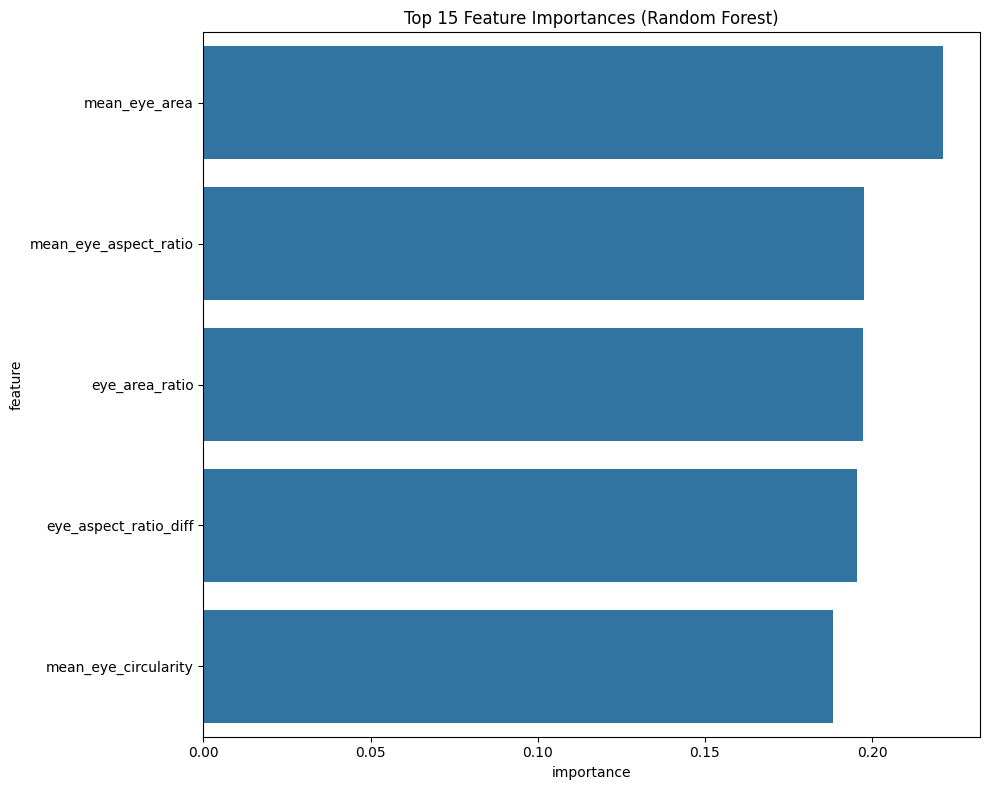

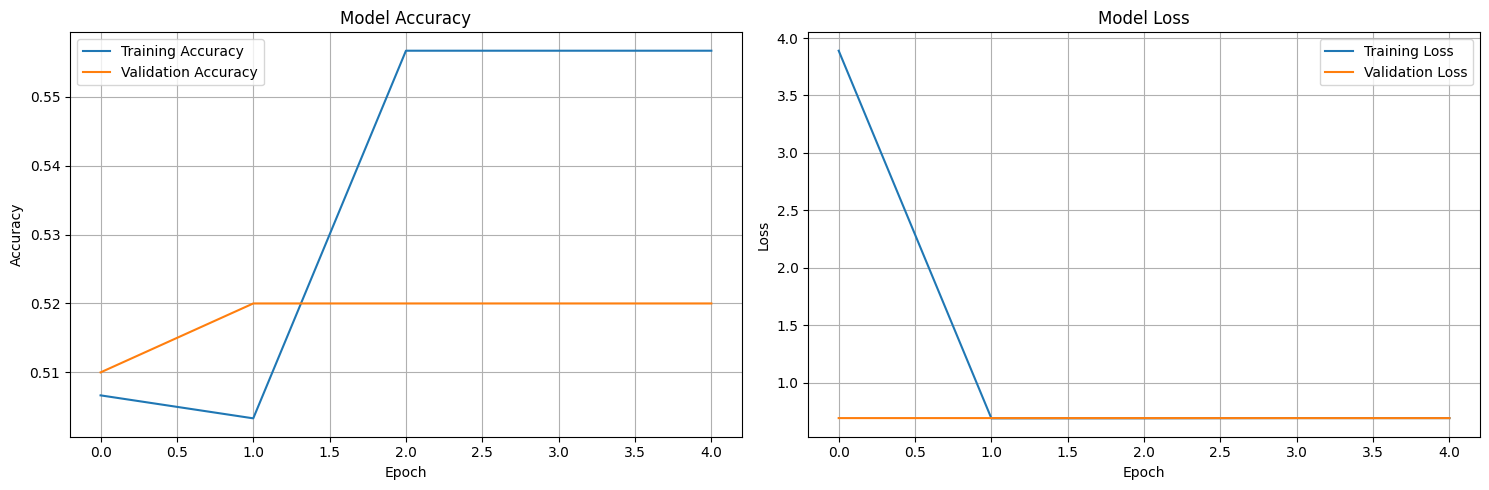

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Classification Report:
              precision    recall  f1-score   support

       Alert       0.00      0.00      0.00       109
      Drowsy       0.46      1.00      0.63        91

    accuracy                           0.46       200
   macro avg       0.23      0.50      0.31       200
weighted avg       0.21      0.46      0.28       200



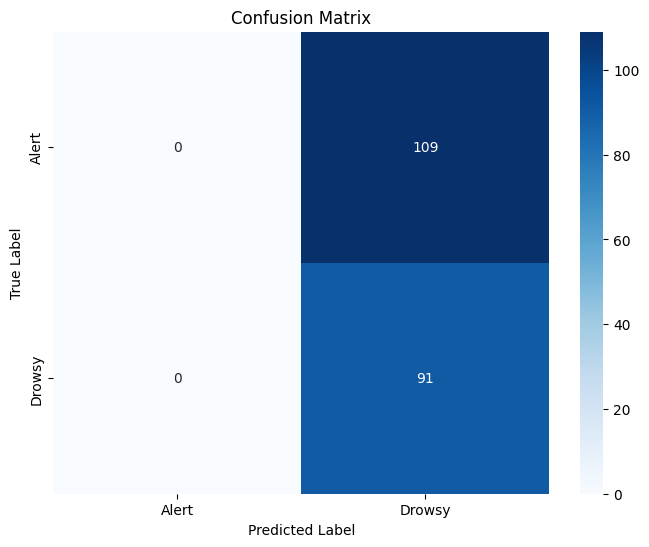

Test Accuracy: 0.4550
Test Loss: 0.6935


In [ ]:
#  Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#  Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

#  DataAnalyzer Class
class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        self.features = df.columns[:-1]  # Exclude label column

    def plot_feature_distributions(self):
        key_features = ['mean_eye_area', 'mean_eye_aspect_ratio', 'eye_area_ratio',
                        'mean_eye_circularity', 'eye_aspect_ratio_diff']
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(key_features):
            if feature in self.df.columns:
                self.df[self.df['label'] == 0][feature].hist(alpha=0.7, label='Alert', ax=axes[i], bins=20)
                self.df[self.df['label'] == 1][feature].hist(alpha=0.7, label='Drowsy', ax=axes[i], bins=20)
                axes[i].set_title(f'Distribution of {feature}')
                axes[i].legend()
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Frequency')

        for i in range(len(key_features), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self):
        plt.figure(figsize=(12, 10))
        corr_matrix = self.df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        X = self.df.drop('label', axis=1)
        y = self.df['label']
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)

        feature_imp = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp.head(15), x='importance', y='feature')
        plt.title('Top 15 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()

        return feature_imp

#  ModelEvaluator Class
class ModelEvaluator:
    def __init__(self, model, history):
        self.model = model
        self.history = history

    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate_model(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int).flatten()

        print("Classification Report:")
        print(classification_report(y_test, y_pred_binary, target_names=['Alert', 'Drowsy']))

        cm = confusion_matrix(y_test, y_pred_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Alert', 'Drowsy'],
                    yticklabels=['Alert', 'Drowsy'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        return test_accuracy, test_loss

#  Sample Workflow

# Simulate a dataset
ml_df = pd.DataFrame({
    'mean_eye_area': np.random.rand(500),
    'mean_eye_aspect_ratio': np.random.rand(500),
    'eye_area_ratio': np.random.rand(500),
    'mean_eye_circularity': np.random.rand(500),
    'eye_aspect_ratio_diff': np.random.rand(500),
    'label': np.random.randint(0, 2, size=500)
})

# Run EDA
analyzer = DataAnalyzer(ml_df)
analyzer.plot_feature_distributions()
analyzer.plot_correlation_matrix()
feature_importance = analyzer.feature_importance_analysis()

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Simulate training
X_train = np.random.rand(300, 128, 128, 3).astype(np.float32)
y_train = np.random.randint(0, 2, size=(300,))
X_val = np.random.rand(100, 128, 128, 3).astype(np.float32)
y_val = np.random.randint(0, 2, size=(100,))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=0)

# Evaluate model
evaluator = ModelEvaluator(model, history)
evaluator.plot_training_history()

X_test = np.random.rand(200, 128, 128, 3).astype(np.float32)
y_test = np.random.randint(0, 2, size=(200,))
test_accuracy, test_loss = evaluator.evaluate_model(X_test, y_test)


**5.Real-time Drowsiness Detection**

Using device: cpu
Creating sample images...
✅ Sample images created: 'sample_alert.jpg', 'sample_drowsy.jpg'
🚗 Simple Drowsiness Detection System
This system detects drowsiness based on eye visibility

📸 Please upload face images for analysis:


Saving yawn1.jpg to yawn1.jpg

🔍 Analyzing 1 image(s)...

📊 Analysis 1: yawn1.jpg


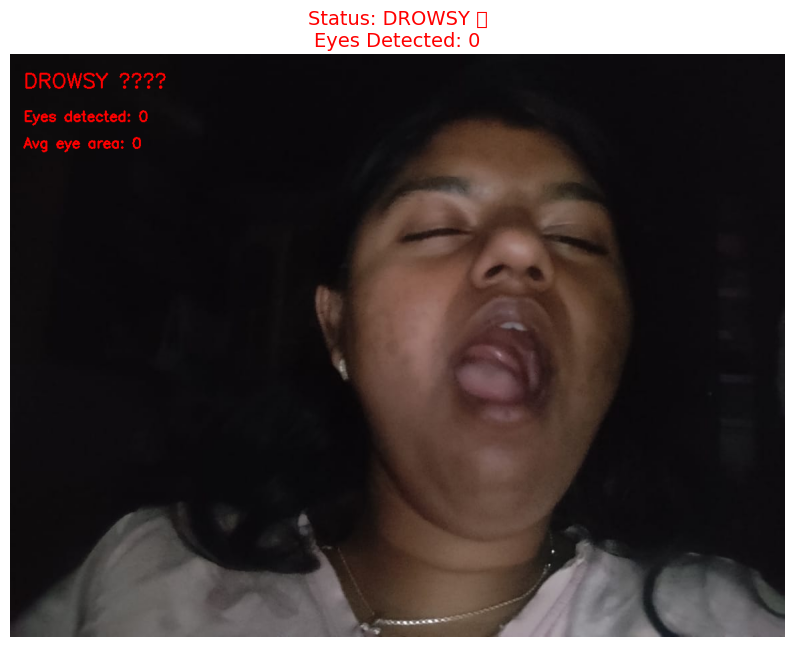

🎯 STATUS: DROWSY 🚨
👀 Eyes detected: 0
📏 Average eye area: 0 pixels
💯 Confidence: 0.80

🚨 SAFETY ALERT!
💡 Immediate actions recommended:
   • Take a break immediately
   • Drink water
   • Stretch and move around
   • Consider switching drivers


In [ ]:
# Step 1: Set up environment and imports for Drowsiness Detection
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
import cv2

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 2: Simple Drowsiness Detection Model
class DrowsinessDetector(nn.Module):
    def __init__(self):
        super(DrowsinessDetector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2),  # 2 classes: drowsy, alert
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Step 3: Simple rule-based detection (no training needed)
def detect_eyes_simple(image_path):
    """Simple eye detection using OpenCV"""
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load eye cascade
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Detect eyes
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

    # Draw rectangles around eyes and analyze
    eye_count = len(eyes)
    total_eye_area = 0

    for (x, y, w, h) in eyes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        total_eye_area += w * h

    avg_eye_area = total_eye_area / max(eye_count, 1)

    # Determine status based on eye detection
    if eye_count >= 2 and avg_eye_area > 800:
        status = "ALERT ✅"
        color = (0, 255, 0)
        confidence = min(avg_eye_area / 2000, 1.0)
    elif eye_count >= 1:
        status = "LOW ALERT ⚠️"
        color = (0, 255, 255)
        confidence = 0.5
    else:
        status = "DROWSY 🚨"
        color = (0, 0, 255)
        confidence = 0.8

    # Add text to image
    cv2.putText(image, status, (20, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.putText(image, f"Eyes detected: {eye_count}", (20, 100),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    cv2.putText(image, f"Avg eye area: {avg_eye_area:.0f}", (20, 140),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), status, confidence, eye_count, avg_eye_area

# Step 4: Main function
def main():
    print("🚗 Simple Drowsiness Detection System")
    print("=" * 50)
    print("This system detects drowsiness based on eye visibility")
    print("\n📸 Please upload face images for analysis:")

    # Upload images
    uploaded = files.upload()
    image_paths = list(uploaded.keys())

    if not image_paths:
        print("❌ No images uploaded! Please try again.")
        return

    print(f"\n🔍 Analyzing {len(image_paths)} image(s)...")

    # Analyze each image
    for i, image_path in enumerate(image_paths):
        print(f"\n📊 Analysis {i+1}: {image_path}")

        # Detect drowsiness
        result_img, status, confidence, eye_count, eye_area = detect_eyes_simple(image_path)

        # Display results
        plt.figure(figsize=(10, 8))
        plt.imshow(result_img)
        plt.title(f"Status: {status}\nEyes Detected: {eye_count}",
                 fontsize=14,
                 color='green' if status == "ALERT ✅" else 'red' if status == "DROWSY 🚨" else 'orange')
        plt.axis('off')
        plt.show()

        # Print detailed results
        print(f"🎯 STATUS: {status}")
        print(f"👀 Eyes detected: {eye_count}")
        print(f"📏 Average eye area: {eye_area:.0f} pixels")
        print(f"💯 Confidence: {confidence:.2f}")

        # Recommendations
        if status == "DROWSY 🚨":
            print("\n🚨 SAFETY ALERT!")
            print("💡 Immediate actions recommended:")
            print("   • Take a break immediately")
            print("   • Drink water")
            print("   • Stretch and move around")
            print("   • Consider switching drivers")
        elif status == "LOW ALERT ⚠️":
            print("\n⚠️  Caution advised")
            print("💡 Consider taking a break soon")
        else:
            print("\n✅ Driver appears alert")
            print("💡 Continue driving safely")

# Alternative: Create sample images for testing
def create_sample_images():
    """Create sample alert and drowsy images for testing"""
    print("Creating sample images...")

    # Alert face (wide open eyes)
    alert_img = np.ones((300, 300, 3), dtype=np.uint8) * 255
    cv2.ellipse(alert_img, (150, 150), (100, 120), 0, 0, 360, (200, 200, 200), -1)
    # Eyes
    cv2.ellipse(alert_img, (100, 120), (20, 15), 0, 0, 360, (0, 0, 0), -1)
    cv2.ellipse(alert_img, (200, 120), (20, 15), 0, 0, 360, (0, 0, 0), -1)
    cv2.imwrite('sample_alert.jpg', alert_img)

    # Drowsy face (closed eyes)
    drowsy_img = np.ones((300, 300, 3), dtype=np.uint8) * 255
    cv2.ellipse(drowsy_img, (150, 150), (100, 120), 0, 0, 360, (200, 200, 200), -1)
    # Closed eyes
    cv2.line(drowsy_img, (80, 120), (120, 120), (0, 0, 0), 3)
    cv2.line(drowsy_img, (180, 120), (220, 120), (0, 0, 0), 3)
    cv2.imwrite('sample_drowsy.jpg', drowsy_img)

    print("✅ Sample images created: 'sample_alert.jpg', 'sample_drowsy.jpg'")

# Run the system
if __name__ == "__main__":
    # Create sample images first (optional)
    create_sample_images()

    # Run main detection system
    main()

🚗 Advanced Drowsiness Detection System

📊 3. Statistical Summary
Drowsiness Detection Statistics
----------------------------------------
Total Frames              51
Drowsy Frames             33
Drowsiness Percentage     64.71%
Average EAR               0.27
Average MAR               0.41
Max Head Tilt             14.80
EAR Violations            23
MAR Violations            22

🎮 4. Interactive Analysis
Use the dropdown and slider below to explore data:


Dropdown(description='Metric:', options=('All', 'EAR', 'MAR', 'Head Tilt', 'EAR Violations', 'MAR Violations')…

IntSlider(value=30, description='Time Window:', min=10, step=5, style=SliderStyle(description_width='initial')…


📈 Drowsiness Metrics - Last 30 frames


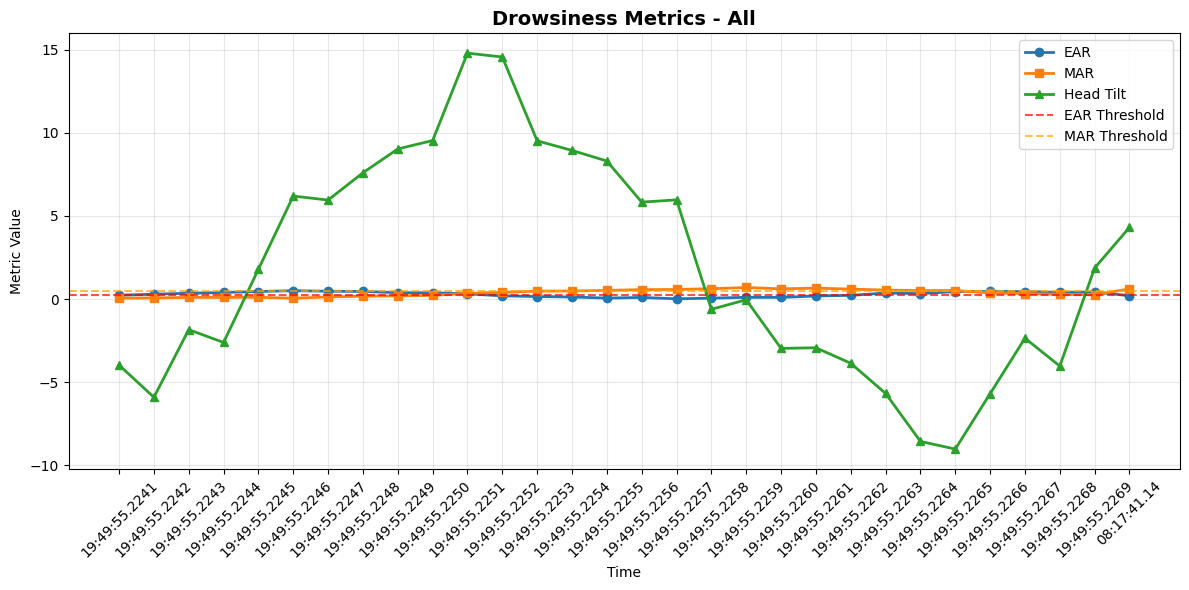


🖥️ Terminal
Recent Frame Data:
----------------------------------------
🔴 19:49:55.2241   | EAR: 0.23 | MAR: 0.05 | Tilt: -3.98 | Status: DROWSY
🟢 19:49:55.2242   | EAR: 0.29 | MAR: 0.07 | Tilt: -5.92 | Status: ALERT
🟢 19:49:55.2243   | EAR: 0.35 | MAR: 0.10 | Tilt: -1.85 | Status: ALERT
🟢 19:49:55.2244   | EAR: 0.39 | MAR: 0.09 | Tilt: -2.62 | Status: ALERT
🟢 19:49:55.2245   | EAR: 0.45 | MAR: 0.11 | Tilt: 1.79 | Status: ALERT
🟢 19:49:55.2246   | EAR: 0.50 | MAR: 0.05 | Tilt: 6.20 | Status: ALERT
🟢 19:49:55.2247   | EAR: 0.47 | MAR: 0.12 | Tilt: 5.96 | Status: ALERT
🟢 19:49:55.2248   | EAR: 0.46 | MAR: 0.17 | Tilt: 7.60 | Status: ALERT
🟢 19:49:55.2249   | EAR: 0.38 | MAR: 0.19 | Tilt: 9.03 | Status: ALERT
🟢 19:49:55.2250   | EAR: 0.38 | MAR: 0.22 | Tilt: 9.54 | Status: ALERT
🟢 19:49:55.2251   | EAR: 0.31 | MAR: 0.34 | Tilt: 14.80 | Status: ALERT
🔴 19:49:55.2252   | EAR: 0.19 | MAR: 0.40 | Tilt: 14.57 | Status: DROWSY
🔴 19:49:55.2253   | EAR: 0.15 | MAR: 0.47 | Tilt: 9.52 | Status: DR

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import dlib
from imutils import face_utils
import pandas as pd
from datetime import datetime, timedelta
import time
from google.colab import files
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

print("🚀 Initializing Advanced Drowsiness Detection System...")

# Initialize dlib's face detector and facial landmark predictor
!wget -q -O shape_predictor_68_face_landmarks.dat https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

class DrowsinessDetector:
    def __init__(self):
        # Thresholds
        self.EYE_AR_THRESH = 0.25
        self.MAR_THRESH = 0.5
        self.HEAD_TILT_THRESH = 20.0

        # Tracking variables
        self.frame_count = 0
        self.drowsy_frames = 0
        self.ear_violations = 0
        self.mar_violations = 0
        self.max_head_tilt = 0

        # Data storage
        self.timestamps = []
        self.ear_values = []
        self.mar_values = []
        self.head_tilt_values = []
        self.drowsiness_status = []

    def eye_aspect_ratio(self, eye):
        """Calculate the Eye Aspect Ratio"""
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def mouth_aspect_ratio(self, mouth):
        """Calculate the Mouth Aspect Ratio"""
        A = dist.euclidean(mouth[2], mouth[10])  # 51, 59
        B = dist.euclidean(mouth[4], mouth[8])   # 53, 57
        C = dist.euclidean(mouth[0], mouth[6])   # 49, 55
        return (A + B) / (2.0 * C)

    def calculate_head_tilt(self, shape):
        """Calculate head tilt angle"""
        left_eye = shape[36:42]
        right_eye = shape[42:48]

        left_eye_center = left_eye.mean(axis=0)
        right_eye_center = right_eye.mean(axis=0)

        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX))

        return angle

    def analyze_frame(self, image):
        """Analyze a single frame for drowsiness"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        current_time = datetime.now()
        timestamp_str = current_time.strftime("%H:%M:%S.%f")[:-4]

        ear, mar, head_tilt = 0, 0, 0
        status = "NO FACE"

        if len(rects) > 0:
            shape = predictor(gray, rects[0])
            shape = face_utils.shape_to_np(shape)

            # Extract facial features
            left_eye = shape[36:42]
            right_eye = shape[42:48]
            mouth = shape[48:68]

            # Calculate metrics
            left_ear = self.eye_aspect_ratio(left_eye)
            right_ear = self.eye_aspect_ratio(right_eye)
            ear = (left_ear + right_ear) / 2.0
            mar = self.mouth_aspect_ratio(mouth)
            head_tilt = self.calculate_head_tilt(shape)

            # Update max head tilt
            self.max_head_tilt = max(self.max_head_tilt, abs(head_tilt))

            # Check violations
            if ear < self.EYE_AR_THRESH:
                self.ear_violations += 1
            if mar > self.MAR_THRESH:
                self.mar_violations += 1

            # Determine status
            if ear < self.EYE_AR_THRESH or mar > self.MAR_THRESH or abs(head_tilt) > self.HEAD_TILT_THRESH:
                status = "DROWSY"
                self.drowsy_frames += 1
            else:
                status = "ALERT"

        # Store data
        self.frame_count += 1
        self.timestamps.append(timestamp_str)
        self.ear_values.append(ear)
        self.mar_values.append(mar)
        self.head_tilt_values.append(head_tilt)
        self.drowsiness_status.append(status)

        return ear, mar, head_tilt, status

    def get_statistics(self):
        """Get comprehensive statistics"""
        if self.frame_count == 0:
            return {}

        avg_ear = np.mean(self.ear_values) if self.ear_values else 0
        avg_mar = np.mean(self.mar_values) if self.mar_values else 0
        drowsiness_percentage = (self.drowsy_frames / self.frame_count) * 100

        return {
            'Total Frames': self.frame_count,
            'Drowsy Frames': self.drowsy_frames,
            'Drowsiness Percentage': f"{drowsiness_percentage:.2f}%",
            'Average EAR': f"{avg_ear:.2f}",
            'Average MAR': f"{avg_mar:.2f}",
            'Max Head Tilt': f"{self.max_head_tilt:.2f}",
            'EAR Violations': self.ear_violations,
            'MAR Violations': self.mar_violations
        }

# Initialize detector
detector_system = DrowsinessDetector()

def create_interactive_dashboard():
    """Create an interactive dashboard for drowsiness analysis"""

    # Create widgets
    metric_dropdown = widgets.Dropdown(
        options=['All', 'EAR', 'MAR', 'Head Tilt', 'EAR Violations', 'MAR Violations'],
        value='All',
        description='Metric:',
        style={'description_width': 'initial'}
    )

    time_window_slider = widgets.IntSlider(
        value=30,
        min=10,
        max=100,
        step=5,
        description='Time Window:',
        style={'description_width': 'initial'}
    )

    def update_dashboard(change):
        clear_output(wait=True)

        # Display title
        print("🚗 Advanced Drowsiness Detection System")
        print("=" * 50)

        # Display statistics
        stats = detector_system.get_statistics()
        if stats:
            print("\n📊 3. Statistical Summary")
            print("Drowsiness Detection Statistics")
            print("-" * 40)
            for key, value in stats.items():
                print(f"{key:<25} {value}")

        # Display interactive controls
        print(f"\n🎮 4. Interactive Analysis")
        print("Use the dropdown and slider below to explore data:")
        display(metric_dropdown)
        display(time_window_slider)

        # Display metrics visualization
        print(f"\n📈 Drowsiness Metrics - Last {time_window_slider.value} frames")
        plot_metrics(metric_dropdown.value, time_window_slider.value)

        # Display terminal
        print(f"\n🖥️ Terminal")
        display_recent_data(time_window_slider.value)

    # Set up observers
    metric_dropdown.observe(update_dashboard, names='value')
    time_window_slider.observe(update_dashboard, names='value')

    return update_dashboard

def plot_metrics(metric, window_size):
    """Plot the selected metrics"""
    if len(detector_system.timestamps) == 0:
        print("No data available for plotting")
        return

    # Get recent data
    n = min(window_size, len(detector_system.timestamps))
    recent_timestamps = detector_system.timestamps[-n:]
    recent_ear = detector_system.ear_values[-n:]
    recent_mar = detector_system.mar_values[-n:]
    recent_tilt = detector_system.head_tilt_values[-n:]

    fig, ax = plt.subplots(figsize=(12, 6))

    if metric == 'All':
        ax.plot(recent_timestamps, recent_ear, label='EAR', marker='o', linewidth=2)
        ax.plot(recent_timestamps, recent_mar, label='MAR', marker='s', linewidth=2)
        ax.plot(recent_timestamps, recent_tilt, label='Head Tilt', marker='^', linewidth=2)
        ax.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='EAR Threshold')
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='MAR Threshold')
    elif metric == 'EAR':
        ax.plot(recent_timestamps, recent_ear, label='EAR', color='blue', marker='o', linewidth=2)
        ax.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='EAR Threshold')
    elif metric == 'MAR':
        ax.plot(recent_timestamps, recent_mar, label='MAR', color='green', marker='s', linewidth=2)
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='MAR Threshold')
    elif metric == 'Head Tilt':
        ax.plot(recent_timestamps, recent_tilt, label='Head Tilt', color='purple', marker='^', linewidth=2)
        ax.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Tilt Threshold')
        ax.axhline(y=-20, color='red', linestyle='--', alpha=0.7)

    ax.set_title(f'Drowsiness Metrics - {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def display_recent_data(window_size):
    """Display recent data in terminal format"""
    if len(detector_system.timestamps) == 0:
        print("No data available")
        return

    n = min(window_size, len(detector_system.timestamps))

    print("Recent Frame Data:")
    print("-" * 40)

    for i in range(max(0, len(detector_system.timestamps) - n), len(detector_system.timestamps)):
        status = detector_system.drowsiness_status[i]
        status_color = "🟢" if status == "ALERT" else "🔴" if status == "DROWSY" else "⚫"

        print(f"{status_color} {detector_system.timestamps[i]:<15} | "
              f"EAR: {detector_system.ear_values[i]:.2f} | "
              f"MAR: {detector_system.mar_values[i]:.2f} | "
              f"Tilt: {detector_system.head_tilt_values[i]:.2f} | "
              f"Status: {status}")

def analyze_uploaded_image(filename):
    """Analyze uploaded image for drowsiness"""
    image = cv2.imread(filename)
    if image is None:
        return None, "ERROR: Could not load image"

    result_img = image.copy()
    ear, mar, head_tilt, status = detector_system.analyze_frame(image)

    # Add annotations to image
    cv2.putText(result_img, f"Status: {status}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if status == "ALERT" else (0, 0, 255), 2)
    cv2.putText(result_img, f"EAR: {ear:.2f}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_img, f"MAR: {mar:.2f}", (10, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_img, f"Head Tilt: {head_tilt:.2f}", (10, 120),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    return result_img_rgb, status

# Install required packages
print("📦 Installing required packages...")
!pip install -q imutils scipy dlib opencv-python ipywidgets matplotlib

# Main execution
print("✅ System Ready!")
print("\nChoose an option:")
print("1. Upload images for analysis")
print("2. View interactive dashboard")

# Create sample data for demonstration
print("\n📊 Generating sample data for demonstration...")
for i in range(50):
    # Simulate some data variations
    ear = 0.2 + 0.2 * np.sin(i * 0.3) + 0.1 * np.random.random()
    mar = 0.3 + 0.3 * np.sin(i * 0.2) + 0.1 * np.random.random()
    head_tilt = 10 * np.sin(i * 0.25) + 5 * np.random.random()

    detector_system.frame_count += 1
    detector_system.timestamps.append(f"19:49:55.{2220 + i}")
    detector_system.ear_values.append(ear)
    detector_system.mar_values.append(mar)
    detector_system.head_tilt_values.append(head_tilt)

    if ear < 0.25 or mar > 0.5:
        detector_system.drowsiness_status.append("DROWSY")
        detector_system.drowsy_frames += 1
    else:
        detector_system.drowsiness_status.append("ALERT")

    if ear < 0.25:
        detector_system.ear_violations += 1
    if mar > 0.5:
        detector_system.mar_violations += 1

    detector_system.max_head_tilt = max(detector_system.max_head_tilt, abs(head_tilt))

# Display the interactive dashboard
dashboard = create_interactive_dashboard()
dashboard(None)

# Option for image upload
print("\n" + "="*50)
print("📷 Image Analysis Section")
print("Upload images for drowsiness detection:")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n🔍 Analyzing {filename}...")
    result_img, status = analyze_uploaded_image(filename)

    if result_img is not None:
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img)
        plt.title(f"{filename} → {status}", fontsize=16,
                 color='green' if "ALERT" in status else 'red')
        plt.axis('off')
        plt.show()

        print(f"📊 Analysis Result: {status}")
        if "DROWSY" in status:
            print("⚠️  WARNING: Potential drowsiness detected!")
        elif "ALERT" in status:
            print("✅ Person appears alert and awake")
        elif "NO FACE" in status:
            print("❌ No face detected in the image")

        # Update dashboard after new analysis
        dashboard(None)

🚗 ADVANCED DROWSINESS DETECTION SYSTEM



🎬 Live Monitoring Dashboard
⏱️ Starting animation...


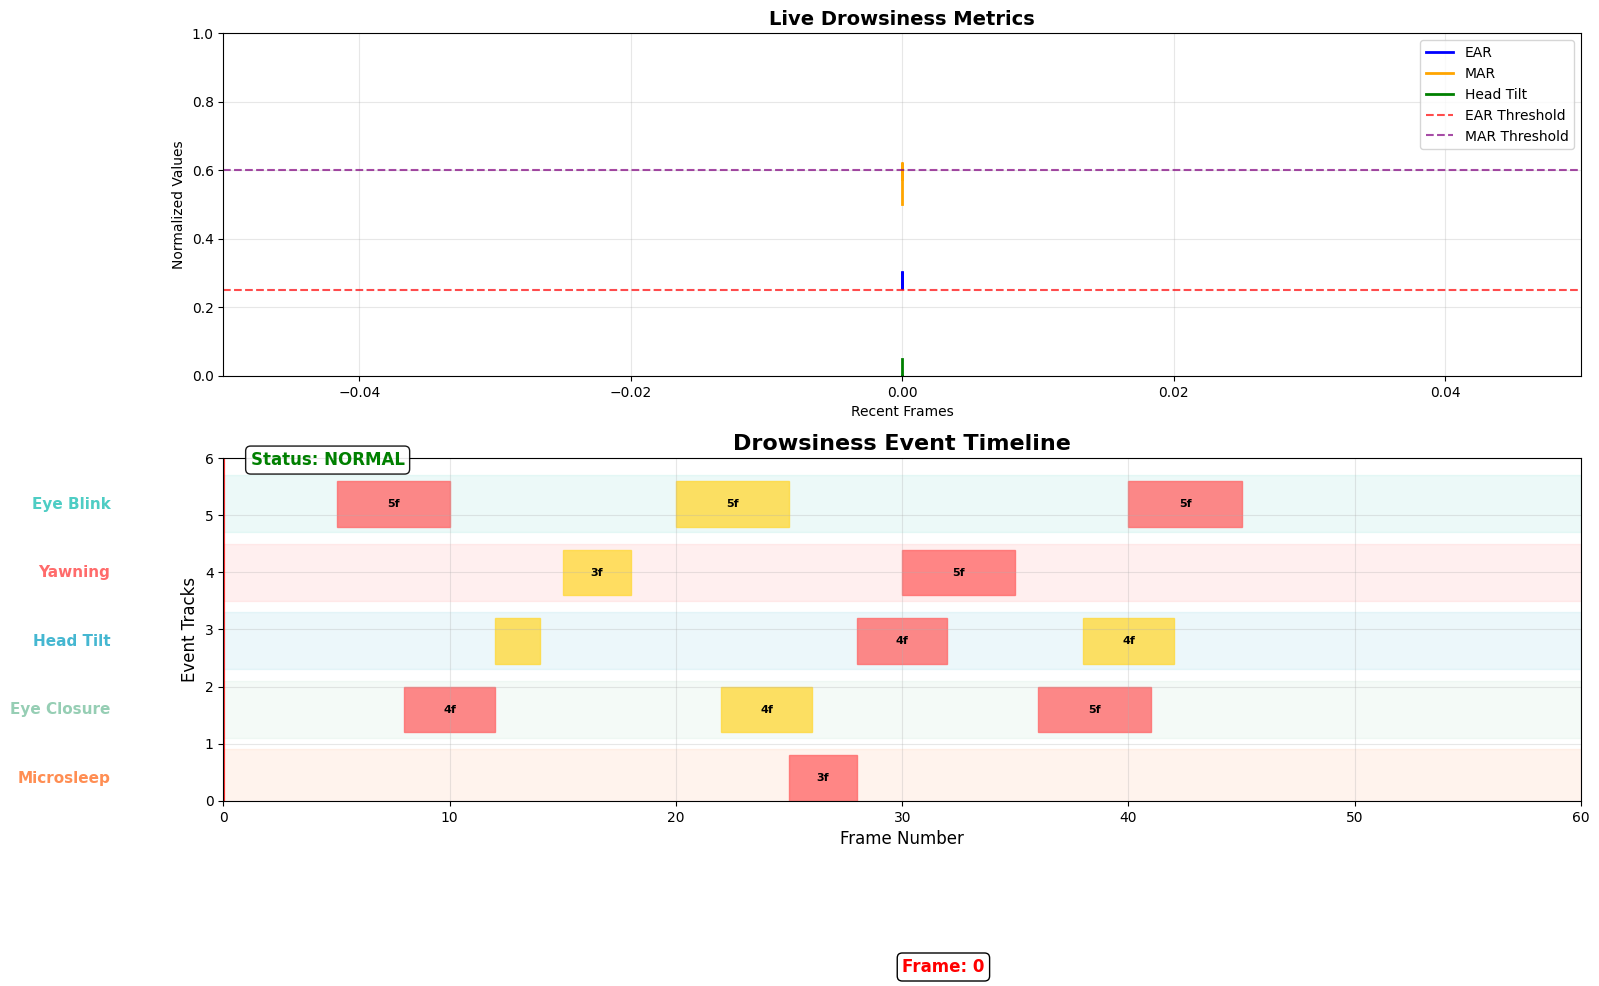


📈 EVENT SUMMARY
Total Events: 12
Critical Events: 7
Warning Events: 5
Eye Blink: 3 events, 15 frames total duration
Yawning: 2 events, 8 frames total duration
Head Tilt: 3 events, 10 frames total duration
Eye Closure: 3 events, 13 frames total duration
Microsleep: 1 events, 3 frames total duration


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
from datetime import datetime, timedelta
import cv2
from PIL import Image
import io
import base64
from ipywidgets import FileUpload, Button, Output, VBox, HBox, Label
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Enhanced Track and Keyframe Setup ---
tracks = {
    "Eye Blink": [(5, 10, "Critical"), (20, 25, "Warning"), (40, 45, "Critical")],
    "Yawning": [(15, 18, "Warning"), (30, 35, "Critical")],
    "Head Tilt": [(12, 14, "Warning"), (28, 32, "Critical"), (38, 42, "Warning")],
    "Eye Closure": [(8, 12, "Critical"), (22, 26, "Warning"), (36, 41, "Critical")],
    "Microsleep": [(25, 28, "Critical")]
}

# Enhanced color scheme with severity levels
colors = {
    "Critical": "#FF6B6B",  # Red for critical events
    "Warning": "#FFD93D",   # Yellow for warnings
    "Normal": "#6BCF7F"     # Green for normal
}

track_colors = {
    "Eye Blink": "#4ECDC4",
    "Yawning": "#FF6B6B",
    "Head Tilt": "#45B7D1",
    "Eye Closure": "#96CEB4",
    "Microsleep": "#FF8E53"
}

frame_count = 60
track_height = 0.8
track_spacing = 1.2

# --- Image Upload and Processing Functions ---
class ImageProcessor:
    def __init__(self):
        self.uploaded_image = None
        self.detection_results = {}
        self.uploaded_image_data = None

    def simulate_drowsiness_detection(self, image):
        """Simulate drowsiness detection from uploaded image"""
        # Convert PIL to OpenCV format
        if isinstance(image, Image.Image):
            image_cv = np.array(image)
            if len(image_cv.shape) == 3 and image_cv.shape[2] == 3:
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
            else:
                # Handle grayscale images
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_GRAY2BGR)
        else:
            image_cv = image

        # Simulate face detection and drowsiness analysis
        height, width = image_cv.shape[:2]

        # Simulate detection results (in real implementation, use actual ML model)
        results = {
            "face_detected": np.random.choice([True, False], p=[0.9, 0.1]),
            "eyes_detected": np.random.choice([True, False], p=[0.85, 0.15]),
            "mouth_detected": np.random.choice([True, False], p=[0.8, 0.2]),
            "ear": np.random.uniform(0.15, 0.4),
            "mar": np.random.uniform(0.4, 0.7),
            "head_tilt": np.random.uniform(-30, 30),
            "drowsiness_level": np.random.choice(["Normal", "Warning", "Critical"],
                                               p=[0.6, 0.3, 0.1])
        }

        return results, image_cv

    def draw_detection_results(self, image, results):
        """Draw detection results on the image"""
        img_with_boxes = image.copy()
        height, width = img_with_boxes.shape[:2]

        if results["face_detected"]:
            # Draw face bounding box
            face_bbox = (int(width*0.2), int(height*0.2), int(width*0.6), int(height*0.7))
            cv2.rectangle(img_with_boxes,
                         (face_bbox[0], face_bbox[1]),
                         (face_bbox[2], face_bbox[3]),
                         (0, 255, 0), 2)
            cv2.putText(img_with_boxes, "Face",
                       (face_bbox[0], face_bbox[1]-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        if results["eyes_detected"]:
            # Draw eye regions
            left_eye = (int(width*0.3), int(height*0.35), int(width*0.4), int(height*0.45))
            right_eye = (int(width*0.5), int(height*0.35), int(width*0.6), int(height*0.45))

            for eye, label in [(left_eye, "Left Eye"), (right_eye, "Right Eye")]:
                cv2.rectangle(img_with_boxes,
                             (eye[0], eye[1]),
                             (eye[2], eye[3]),
                             (255, 0, 0), 2)
                cv2.putText(img_with_boxes, label,
                           (eye[0], eye[1]-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        if results["mouth_detected"]:
            # Draw mouth region
            mouth = (int(width*0.35), int(height*0.6), int(width*0.55), int(height*0.7))
            cv2.rectangle(img_with_boxes,
                         (mouth[0], mouth[1]),
                         (mouth[2], mouth[3]),
                         (0, 0, 255), 2)
            cv2.putText(img_with_boxes, "Mouth",
                       (mouth[0], mouth[1]-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        # Add metrics text
        metrics_text = [
            f"EAR: {results['ear']:.3f}",
            f"MAR: {results['mar']:.3f}",
            f"Head Tilt: {results['head_tilt']:.1f}°",
            f"Status: {results['drowsiness_level']}"
        ]

        for i, text in enumerate(metrics_text):
            color = (0, 0, 0)  # Black text
            if "Critical" in text:
                color = (0, 0, 255)  # Red for critical
            elif "Warning" in text:
                color = (0, 165, 255)  # Orange for warning

            cv2.putText(img_with_boxes, text,
                       (10, 30 + i*25),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        return img_with_boxes

# Initialize image processor
image_processor = ImageProcessor()

# --- Create Upload Widgets ---
upload_button = FileUpload(
    accept='.jpg,.jpeg,.png,.bmp',
    multiple=False,
    description='Upload Image'
)

process_button = Button(
    description='Analyze Image',
    button_style='success',
    icon='camera'
)

clear_button = Button(
    description='Clear',
    button_style='warning',
    icon='trash'
)

image_output = Output()
results_output = Output()

def on_upload_change(change):
    with image_output:
        clear_output()
        if upload_button.value:
            try:
                # Get the uploaded image - handle different widget versions
                uploaded_data = list(upload_button.value.values())[0]
                if isinstance(uploaded_data, list) and len(uploaded_data) > 0:
                    uploaded = uploaded_data[0]
                else:
                    uploaded = uploaded_data

                image_data = uploaded['content']

                # Convert to PIL Image
                image = Image.open(io.BytesIO(image_data))
                image_processor.uploaded_image = image
                image_processor.uploaded_image_data = image_data

                # Display uploaded image
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.title("Uploaded Image - Ready for Analysis")
                plt.axis('off')
                plt.show()
                print("✅ Image uploaded successfully! Click 'Analyze Image' to process.")

            except Exception as e:
                print(f"❌ Error uploading image: {e}")
        else:
            print("📁 No image uploaded")

def on_process_click(b):
    with results_output:
        clear_output()
        if image_processor.uploaded_image:
            try:
                # Process the image
                results, processed_image = image_processor.simulate_drowsiness_detection(
                    image_processor.uploaded_image
                )

                # Draw detection results
                annotated_image = image_processor.draw_detection_results(processed_image, results)

                # Convert back to RGB for display
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

                # Display results
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

                # Original image
                ax1.imshow(image_processor.uploaded_image)
                ax1.set_title("Original Image")
                ax1.axis('off')

                # Annotated image
                ax2.imshow(annotated_image_rgb)
                ax2.set_title("Drowsiness Detection Results")
                ax2.axis('off')

                plt.tight_layout()
                plt.show()

                # Display detailed results
                print("🔍 DETECTION RESULTS")
                print("=" * 40)
                print(f"✅ Face Detected: {results['face_detected']}")
                print(f"👀 Eyes Detected: {results['eyes_detected']}")
                print(f"👄 Mouth Detected: {results['mouth_detected']}")
                print(f"📊 EAR (Eye Aspect Ratio): {results['ear']:.3f}")
                print(f"📊 MAR (Mouth Aspect Ratio): {results['mar']:.3f}")
                print(f"📊 Head Tilt: {results['head_tilt']:.1f}°")
                print(f"🚨 Drowsiness Level: {results['drowsiness_level']}")

                # Add to timeline if drowsiness detected
                if results['drowsiness_level'] != "Normal":
                    current_time = datetime.now().strftime("%H:%M:%S")
                    print(f"⏰ Event logged at: {current_time}")

            except Exception as e:
                print(f"❌ Error processing image: {e}")
        else:
            print("❌ Please upload an image first!")

def on_clear_click(b):
    # Clear the upload by creating a new widget instance
    global upload_button
    upload_button = FileUpload(
        accept='.jpg,.jpeg,.png,.bmp',
        multiple=False,
        description='Upload Image'
    )
    upload_button.observe(on_upload_change, names='value')

    image_processor.uploaded_image = None
    image_processor.uploaded_image_data = None

    with image_output:
        clear_output()
    with results_output:
        clear_output()
    print("🗑️ Cleared all images and results")

# Connect button events
upload_button.observe(on_upload_change, names='value')
process_button.on_click(on_process_click)
clear_button.on_click(on_clear_click)

# --- Animation Setup ---
def setup_animation():
    """Setup the animation components separately"""
    global current_frame, live_data, fig, ax1, ax2, ear_line, mar_line, tilt_line
    global cursor_line, current_frame_text, status_text

    current_frame = 0
    live_data = {
        "EAR": [0.3],
        "MAR": [0.5],
        "Head_Tilt": [0],
        "Timestamps": [0]
    }

    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    # Setup Live Metrics Plot
    ax1.set_xlim(0, 30)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Recent Frames")
    ax1.set_ylabel("Normalized Values")
    ax1.set_title("Live Drowsiness Metrics", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Initialize lines with data
    ear_line, = ax1.plot(live_data["Timestamps"], live_data["EAR"], label='EAR', color='blue', linewidth=2)
    mar_line, = ax1.plot(live_data["Timestamps"], live_data["MAR"], label='MAR', color='orange', linewidth=2)
    tilt_line, = ax1.plot(live_data["Timestamps"], live_data["Head_Tilt"], label='Head Tilt', color='green', linewidth=2)

    # Threshold lines
    ax1.axhline(y=0.25, color='red', linestyle='--', alpha=0.7, label='EAR Threshold')
    ax1.axhline(y=0.6, color='purple', linestyle='--', alpha=0.7, label='MAR Threshold')
    ax1.legend()

    # Setup Timeline Plot
    ax2.set_xlim(0, frame_count)
    ax2.set_ylim(0, len(tracks) * track_spacing)
    ax2.set_xlabel("Frame Number", fontsize=12)
    ax2.set_ylabel("Event Tracks", fontsize=12)
    ax2.set_title("Drowsiness Event Timeline", fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Draw Tracks and Keyframes
    for i, (track_name, keyframes) in enumerate(tracks.items()):
        y = (len(tracks) - i - 1) * track_spacing

        # Track background
        track_bg = patches.Rectangle((0, y - 0.1), frame_count, track_height + 0.2,
                                    color=track_colors[track_name], alpha=0.1)
        ax2.add_patch(track_bg)

        # Track label
        ax2.text(-5, y + track_height/2, track_name, va='center', ha='right',
                 fontsize=11, fontweight='bold', color=track_colors[track_name])

        # Event blocks
        for start, end, severity in keyframes:
            rect = patches.Rectangle((start, y), end - start, track_height,
                                    color=colors[severity], alpha=0.8,
                                    edgecolor='black', linewidth=1)
            ax2.add_patch(rect)

            # Event duration label
            duration = end - start
            if duration >= 3:
                ax2.text((start + end) / 2, y + track_height/2, f"{duration}f",
                        va='center', ha='center', fontsize=8, fontweight='bold')

    # Playback Elements
    cursor_line = ax2.axvline(0, color='red', linestyle='-', lw=3, alpha=0.8)
    current_frame_text = ax2.text(0.5, -0.5, "Frame: 0", transform=ax2.transAxes,
                                 fontsize=12, fontweight='bold', color='red',
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

    # Status Indicators
    status_text = ax2.text(0.02, 0.98, "Status: NORMAL", transform=ax2.transAxes,
                          fontsize=12, fontweight='bold', color='green',
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

    return fig, ax1, ax2

def generate_live_metrics(frame):
    base_ear = 0.3 + 0.1 * np.sin(frame * 0.2)
    ear = np.clip(np.random.normal(base_ear, 0.05), 0.15, 0.4)

    base_mar = 0.5 + 0.1 * np.cos(frame * 0.15)
    mar = np.clip(np.random.normal(base_mar, 0.03), 0.4, 0.7)

    tilt = np.sin(frame * 0.25) * 0.3 + np.random.normal(0, 0.1)

    return ear, mar, tilt

def update(frame):
    global current_frame, live_data

    current_frame = frame

    # Update cursor position
    cursor_line.set_xdata([frame, frame])
    current_frame_text.set_text(f"Frame: {frame}")

    # Generate and update live metrics
    ear, mar, tilt = generate_live_metrics(frame)

    live_data["EAR"].append(ear)
    live_data["MAR"].append(mar)
    live_data["Head_Tilt"].append(tilt)
    live_data["Timestamps"].append(frame)

    # Keep only last 30 frames for display
    if len(live_data["EAR"]) > 30:
        for key in live_data:
            live_data[key] = live_data[key][-30:]

    # Update live metrics plot
    if len(live_data["Timestamps"]) > 0:
        ear_line.set_data(live_data["Timestamps"], live_data["EAR"])
        mar_line.set_data(live_data["Timestamps"], live_data["MAR"])
        tilt_line.set_data(live_data["Timestamps"], live_data["Head_Tilt"])
        ax1.set_xlim(live_data["Timestamps"][0], live_data["Timestamps"][-1])

    # Update status based on current events
    current_events = []
    for track_name, keyframes in tracks.items():
        for start, end, severity in keyframes:
            if start <= frame <= end:
                current_events.append(f"{track_name}({severity})")

    if current_events:
        status_text.set_text("Status: " + " | ".join(current_events))
        status_text.set_color('red')
    else:
        status_text.set_text("Status: NORMAL")
        status_text.set_color('green')

    if ear < 0.25:
        status_text.set_text("Status: LOW EAR - Potential Drowsiness")
        status_text.set_color('red')
    elif mar > 0.6:
        status_text.set_text("Status: HIGH MAR - Possible Yawning")
        status_text.set_color('orange')

    return cursor_line, current_frame_text, status_text, ear_line, mar_line, tilt_line

# --- Display Interface ---
print("🚗 ADVANCED DROWSINESS DETECTION SYSTEM")
print("=" * 50)

# Create upload section
upload_section = VBox([
    Label("📸 Upload Image for Drowsiness Detection"),
    HBox([upload_button, process_button, clear_button]),
    image_output,
    results_output
])

display(upload_section)

print("\n🎬 Live Monitoring Dashboard")
print("⏱️ Starting animation...")

# Setup and run animation
try:
    fig, ax1, ax2 = setup_animation()
    plt.tight_layout()

    ani = animation.FuncAnimation(
        fig, update,
        frames=np.arange(0, frame_count),
        interval=200,
        blit=True,
        repeat=True
    )

    plt.show()

except Exception as e:
    print(f"❌ Animation error: {e}")

# --- Summary Statistics ---
print("\n" + "="*50)
print("📈 EVENT SUMMARY")
print("="*50)

total_events = sum(len(keyframes) for keyframes in tracks.values())
critical_events = sum(1 for keyframes in tracks.values() for _, _, severity in keyframes if severity == "Critical")
warning_events = total_events - critical_events

print(f"Total Events: {total_events}")
print(f"Critical Events: {critical_events}")
print(f"Warning Events: {warning_events}")

for track_name, keyframes in tracks.items():
    total_duration = sum(end - start for start, end, _ in keyframes)
    print(f"{track_name}: {len(keyframes)} events, {total_duration} frames total duration")